## POS tagging using modified Viterbi

### Data Preparation

In [1]:
#Importing libraries
import nltk
import random
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import progressbar
# nltk.download('universal_tagset')

In [2]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))
nltk_data[:1]

[[('Pierre', 'NOUN'),
  ('Vinken', 'NOUN'),
  (',', '.'),
  ('61', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  (',', '.'),
  ('will', 'VERB'),
  ('join', 'VERB'),
  ('the', 'DET'),
  ('board', 'NOUN'),
  ('as', 'ADP'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
  ('director', 'NOUN'),
  ('Nov.', 'NOUN'),
  ('29', 'NUM'),
  ('.', '.')]]

In [3]:
# Splitting into train and test into 95:5 ratio respectively
random.seed(1234)
train_set, test_set = train_test_split(nltk_data, test_size=0.05)

In [4]:
# Checking the length of training and test set
print(len(train_set), len(test_set))

3718 196


In [5]:
train_set[:2]

[[('Profit', 'NOUN'),
  ('from', 'ADP'),
  ('continuing', 'VERB'),
  ('operations', 'NOUN'),
  ('has', 'VERB'),
  ('soared', 'VERB'),
  ('to', 'PRT'),
  ('$', '.'),
  ('467', 'NUM'),
  ('million', 'NUM'),
  ('*U*', 'X'),
  ('from', 'ADP'),
  ('$', '.'),
  ('75', 'NUM'),
  ('million', 'NUM'),
  ('*U*', 'X'),
  ('.', '.')],
 [('The', 'DET'),
  ('filing', 'NOUN'),
  ('on', 'ADP'),
  ('the', 'DET'),
  ('details', 'NOUN'),
  ('of', 'ADP'),
  ('the', 'DET'),
  ('spinoff', 'NOUN'),
  ('caused', 'VERB'),
  ('Cray', 'NOUN'),
  ('Research', 'NOUN'),
  ('stock', 'NOUN'),
  ('to', 'PRT'),
  ('jump', 'VERB'),
  ('$', '.'),
  ('2.875', 'NUM'),
  ('*U*', 'X'),
  ('yesterday', 'NOUN'),
  ('*-1', 'X'),
  ('to', 'PRT'),
  ('close', 'VERB'),
  ('at', 'ADP'),
  ('$', '.'),
  ('38', 'NUM'),
  ('*U*', 'X'),
  ('in', 'ADP'),
  ('New', 'NOUN'),
  ('York', 'NOUN'),
  ('Stock', 'NOUN'),
  ('Exchange', 'NOUN'),
  ('composite', 'ADJ'),
  ('trading', 'NOUN'),
  ('.', '.')]]

In [6]:
# Creating list of tagged words
train_tagged_words = [tupple for w in train_set for tupple in w]
train_words = [tupple[0] for w in train_set for tupple in w]
train_tags = [tupple[1] for w in train_set for tupple in w]

In [7]:
# Verifying whether the unpack was successful
print(len(train_words), len(train_tags))
print(train_words[:2], train_tags[:2])

95795 95795
['Profit', 'from'] ['NOUN', 'ADP']


In [8]:
# Get unique words and tag available in the corpus
unique_train_words = set(train_words)
unique_train_tags = set(train_tags)

In [9]:
print(len(unique_train_words),len(unique_train_tags))
print(unique_train_tags)

12073 12
{'CONJ', 'DET', 'PRT', 'X', 'NOUN', 'ADJ', 'ADV', 'ADP', 'NUM', '.', 'PRON', 'VERB'}


`Inference: ` There are 12074 out of 95527 unique words. Also there are 12 different type of unique tags used in the corpus.

In [10]:
# Before proceeding further with the vanilla Viterbi based POS tagger
# Let's first create a set pf emission probabilities as they will be same through out the corpus
# We are doing this to avoid computional power to calculate them while labelling POS tag in Viterbi algorithm
# I will be using Emission Probability and Transition Probability code

In [11]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [12]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(unique_train_tags), len(unique_train_tags)), dtype='float32')
for i, t1 in enumerate(list(unique_train_tags)):
    for j, t2 in enumerate(list(unique_train_tags)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [13]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(unique_train_tags), index=list(unique_train_tags))
tags_df

,CONJ,DET,PRT,X,NOUN,ADJ,ADV,ADP,NUM,.,PRON,VERB
CONJ,0.000464,0.118439,0.005109,0.008360,0.344635,0.117046,0.054807,0.055272,0.042731,0.036693,0.058059,0.158384
DET,0.000361,0.005180,0.000241,0.045175,0.639923,0.205156,0.012890,0.009035,0.022046,0.017347,0.003734,0.038911
PRT,0.002277,0.100846,0.001952,0.013338,0.242681,0.084255,0.009759,0.020494,0.059206,0.043917,0.017892,0.403383
X,0.009992,0.055511,0.185884,0.075178,0.062014,0.016971,0.025059,0.142585,0.002696,0.163838,0.056622,0.203648
NOUN,0.042418,0.013324,0.043951,0.029313,0.263087,0.012265,0.016975,0.177338,0.009090,0.240308,0.004746,0.147186
ADJ,0.017052,0.005083,0.010494,0.021151,0.698147,0.067388,0.004755,0.077390,0.020331,0.065421,0.000492,0.012297
ADV,0.006917,0.067852,0.013505,0.023386,0.032609,0.128788,0.080369,0.119565,0.031950,0.136364,0.014163,0.344532
ADP,0.000745,0.326057,0.001491,0.033862,0.321372,0.106378,0.013950,0.016612,0.062613,0.039293,0.069109,0.008519
NUM,0.014201,0.002959,0.028107,0.209467,0.354438,0.033136,0.002959,0.036095,0.184320,0.115089,0.001479,0.017751
.,0.058728,0.171965,0.002335,0.027389,0.221624,0.043912,0.053161,0.091864,0.081448,0.093032,0.066631,0.087823


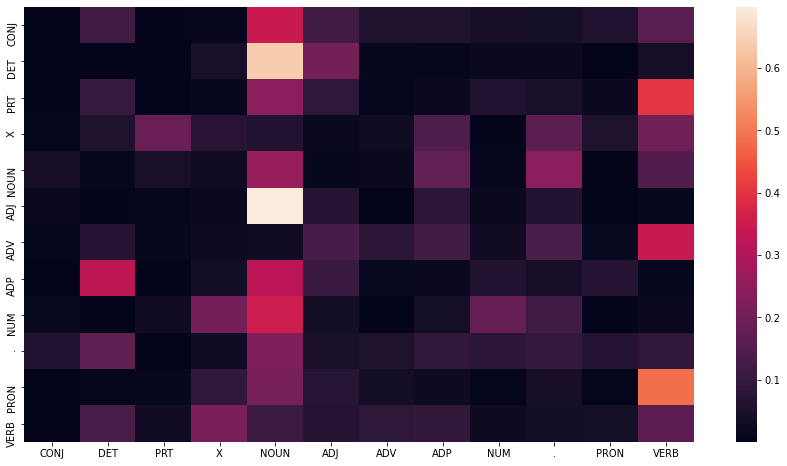

In [14]:
# heatmap of tags matrix
plt.figure(figsize=(15, 8))
sns.heatmap(tags_df)
plt.show()

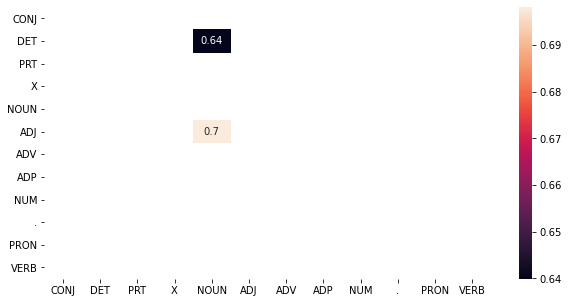

In [15]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(10, 5))
sns.heatmap(tags_frequent, annot = True)
plt.show()

In [16]:
# Now after having transition probabilities calculated let's create a vanilla Viterbi algorithm

### Build the vanilla Viterbi based POS tagger

In [17]:
train_tagged_words[:2]

[('Profit', 'NOUN'), ('from', 'ADP')]

In [18]:
tag_word_dict = {}
pbar = progressbar.ProgressBar()
for word in pbar(train_tagged_words):
    tag_word_dict.setdefault(word[1], []).append(word[0])
#     print(word[0])
# tag_word_dict

100% (95795 of 95795) |##################| Elapsed Time: 0:00:00 Time:  0:00:00


In [19]:
# Before assigning tags to the words we also need Emission Probability
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1] == tag]
#     print(tag_list)
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0] == word]
    count_w_given_tag = len(w_given_tag_list)
#     print(tag, tag_word_dict.get(tag))
#     count_w_given_tag = tag_word_dict.get(tag).count(word)
    
    return (count_w_given_tag, count_tag)

In [20]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    pbar = progressbar.ProgressBar(
                max_value=len(words),
                widgets=[' [', progressbar.Timer(), '] ', progressbar.Bar(), ' (', progressbar.ETA(), ') '])
    for key, word in pbar(enumerate(words)):
        #initialise list of probability column for a given observation
        p = []
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [21]:
# Let's create test dataset on which we want to run the vanilla Viterbie algorithm
# Creating list of tagged words

# Running on entire test dataset would take more than 3-4hrs. 
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(1234)

# choose random 5 sents
sentences_rand = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_sent = [test_set[i] for i in sentences_rand]

# list of tagged words
test_sent_words = [tup for sent in test_sent for tup in sent]

# list of untagged words
subset_test_tagged_words = [tup[0] for sent in test_sent for tup in sent]

In [22]:
tagged_seq = Viterbi(subset_test_tagged_words)

 [Elapsed Time: 0:00:16] |##################################| (Time:  0:00:16) 


In [23]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_sent_words) if i == j]
vanilla_viterbi_accuracy = len(check)/len(tagged_seq)
vanilla_viterbi_accuracy

0.9122807017543859

`Inference: ` Vanila Viterbi is giving accuracy of 91%.

In [24]:
incorrect_tagged_cases = [[test_sent_words[i-1],j] for i, j in enumerate(zip(tagged_seq, test_sent_words)) if j[0]!=j[1]]
incorrect_tagged_cases

[[('a', 'DET'), (('blank', 'CONJ'), ('blank', 'NOUN'))],
 [("''", '.'), (('Mortgage-Backed', 'CONJ'), ('Mortgage-Backed', 'NOUN'))],
 [('is', 'VERB'), (('payable', 'CONJ'), ('payable', 'ADJ'))],
 [('payable', 'ADJ'), (('Jan.', 'CONJ'), ('Jan.', 'NOUN'))],
 [('*', 'X'), (('Arbitraging', 'CONJ'), ('Arbitraging', 'VERB'))]]

In [25]:
# Let's look at words which are there in test set but not there in training set
test_tagged_words = [tupple for w in test_set for tupple in w]
test_words = [tupple[0] for w in test_set for tupple in w]
test_tags = [tupple[1] for w in test_set for tupple in w]
unique_test_words = set(test_words)

In [26]:
# Unknown words 

test_vocabulary_set = set([t for t in test_tagged_words])

unknown_words = list(unique_test_words - unique_train_words)
print(len(unknown_words))

335


`Inference: ` There are 334 words that are unique in our test corpus. Because of these words Viterbi is not able to give high accuracy. Next let's modify Viterbi algorithm to overcome the issue where unknown words are not labelled properly.

## Solve the problem of unknown words

### Modification 1: Laplace Smoothing
Here I am checking if the emission probability is zero. i.e. Word doesn't exists in the training corpus. Then in that case I am adding 1 to the emission emission probability.

The reason I am doing this is, so that overall probability is not zero.

In [29]:
# Modified Viterbi Heuristic
def Modified_Laplace_Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    pbar = progressbar.ProgressBar(
                max_value=len(words),
                widgets=[' [', progressbar.Timer(), '] ', progressbar.Bar(), ' (', progressbar.ETA(), ') '])
    for key, word in pbar(enumerate(words)):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            
            # Here instead of mutiplying the emission probability everytime
            # We are multiplying emission probability on when the word exists in the training corpus
            if word not in train_words:
                state_probability = (emission_p +1) * transition_p
            else:
                state_probability = emission_p * transition_p
                
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [30]:
tagged_seq = Modified_Laplace_Viterbi(subset_test_tagged_words)

 [Elapsed Time: 0:00:15] |##################################| (Time:  0:00:15) 


In [31]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_sent_words) if i == j]
modified_Laplace_Viterbi_accuracy = len(check)/len(tagged_seq)
modified_Laplace_Viterbi_accuracy

0.9649122807017544

In [32]:
incorrect_tagged_cases = [[test_sent_words[i-1],j] for i, j in enumerate(zip(tagged_seq, test_sent_words)) if j[0]!=j[1]]
incorrect_tagged_cases

[[('is', 'VERB'), (('payable', 'X'), ('payable', 'ADJ'))],
 [('payable', 'ADJ'), (('Jan.', 'VERB'), ('Jan.', 'NOUN'))]]

`Inference: ` After doing modification to Viterbi Agorithm, the accuracy got increased by approx 5%. Here I have done laplase smoothing where I am adding 1 to emission probability if the word doesn't exists in the training corpus. And depending on the transition probability.

The reason I am doing this is since word doesn't exists in the training corpus, so the emission probability is zero.

## Checking accuracy with other models

After making change to the Viterbi Algorithm we saw there is an improvement in the model. Another approach that we can follow is to combine multiple algorithms. Like:
1. Viterbi and Lexicon tagger
2. Viterbi with rule based tagger

Let's try them next.

In [33]:
## Let's start with the rule based tagger
patterns = [
    (r'[0-9].?[,\/]?[0-9]*','NUM'),     # Numbers 
    (r'^[aA-zZ].*[0-9]+','NOUN'),       # Alpha Numeric
    (r'.*ing$', 'VERB'),                # gerunds
    (r'.*ed$', 'VERB'),                 # simple past
    (r'.*es$', 'VERB'),                 # 3rd singular present
    (r'.*ould$', 'X'),                  # modals
    (r'.*\'s$', 'NOUN'),                # possessive nouns
    (r'.*s$', 'NOUN'),                  # plural nouns
    (r'.*', 'NOUN'),                    # nouns (default)
    (r'(The|the|A|a|An|an)$', 'DET'),
    (r'.*ness$', 'NOUN'),
    (r'.*ly$', 'ADV'),
    (r'^(0|([*|-|$].*))','X'),          # Any special character
]

# The above rules are taken from: https://www.nltk.org/book/ch05.html

In [34]:
rule_based_tagger = nltk.RegexpTagger(patterns)
rule_based_tagger.evaluate(test_set)

0.3458307723827085

In [35]:
# Unigram Tagger
unigram_tagger = nltk.UnigramTagger(train_set)
unigram_tagger_accuracy = unigram_tagger.evaluate(test_set)
print(unigram_tagger_accuracy)

0.9026838762548658


In [36]:
# Unigram tagger backoff with rule based tagger
unigram_tagger_rule_based = nltk.UnigramTagger(train_set, backoff = rule_based_tagger)
unigram_tagger_rule_based.evaluate(test_set)

0.9469371030526531

In [37]:
# Bigram tagger backoff with unigram tagger

bigram_tagger = nltk.BigramTagger(train_set, backoff = unigram_tagger_rule_based)
bigram_tagger.evaluate(test_set)

0.9545175169022742

In [38]:
# Trigram tagger backoff with bigram tagger

trigram_tagger = nltk.TrigramTagger(train_set, backoff = bigram_tagger)
trigram_tagger.evaluate(test_set)

0.9530833845523459

`Inference: ` Since we are getting best accuarcy with trigram tagger backoff with biagram tagger, let's use it in combination to modified Viterbi algorithm as in case 1.

In [39]:
def Viterbi_modification_trigram_tagger(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    pbar = progressbar.ProgressBar(
                max_value=len(words),
                widgets=[' [', progressbar.Timer(), '] ', progressbar.Bar(), ' (', progressbar.ETA(), ') '])
    for key, word in pbar(enumerate(words)):
        # Modification: If word doesn't exists in the training corpus
        # We are using trigram tagger
        if word not in train_words:
            trigram_tag = trigram_tagger.tag_sents([[(word)]])
            for sent in trigram_tag:
                for tup in sent:
                    state.append(tup[1])
        else:
            #initialise list of probability column for a given observation
            p = [] 
            for tag in T:
                if key == 0:
                    transition_p = tags_df.loc['.', tag]
                else:
                    transition_p = tags_df.loc[state[-1], tag]

                # compute emission and state probabilities
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]

                state_probability = emission_p * transition_p

                p.append(state_probability)

            pmax = max(p)
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)] 
            state.append(state_max)
    return list(zip(words, state))

In [40]:
tagged_seq = Viterbi_modification_trigram_tagger(subset_test_tagged_words)

 [Elapsed Time: 0:00:14] |##################################| (Time:  0:00:14) 


In [41]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_sent_words) if i == j]
viterbi_modification_trigram_tagger_accuracy = len(check)/len(tagged_seq)
viterbi_modification_trigram_tagger_accuracy

0.9649122807017544

In [42]:
incorrect_tagged_cases = [[test_sent_words[i-1],j] for i, j in enumerate(zip(tagged_seq, test_sent_words)) if j[0]!=j[1]]
incorrect_tagged_cases

[[("''", '.'), (('Mortgage-Backed', 'VERB'), ('Mortgage-Backed', 'NOUN'))],
 [('is', 'VERB'), (('payable', 'NOUN'), ('payable', 'ADJ'))]]

`Inference: ` After doing second level of modification to Viterbi Agorithm, the accuracy got further increased by approx 2%. Here I have combined viterbi with trigram tagger backoff with bigram, unigram and rule based tagger.

For the unknown words (i.e. words that doesn't exist's in the training corpus, for those words I am running trigram tagger followed by bigram tagger. Doing this is helping me in the inclrease of the accuracy.

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

<AxesSubplot:xlabel='0'>

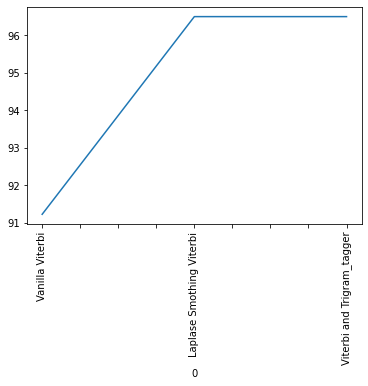

In [43]:
# columns = []
accuracy_metrics = {
    'Vanilla Viterbi': vanilla_viterbi_accuracy * 100, 
    'Laplase Smothing Viterbi': modified_Laplace_Viterbi_accuracy * 100,
    'Viterbi and Trigram_tagger': viterbi_modification_trigram_tagger_accuracy * 100
}
accuracy_metrics
accuracy_df = pd.DataFrame(accuracy_metrics.items())
accuracy_df.set_index(0, inplace = True)
accuracy_df.plot.line(rot = 90, legend = False)

`Inference: ` It states that the Viterbi with combination with Trigram_tagger is showing the best accuracy.

In [44]:
## Next let's check the accuracy of the provided sentences.
## The provided sentences are not tagged therefore firstly I will be tagging them using nltk library.
## This will help me to check the accuracy.

In [45]:
# Reading sentences fromt the text file
with open('Test_sentences.txt', 'r') as f:
    sentences = f.readlines()
sentences = map(lambda s: s.strip(), sentences)
sentences = list(sentences)

In [46]:
# Cleaning up the data
sentences_list = [x for x in sentences if x]

In [47]:
sentences_list

['Android is a mobile operating system developed by Google.',
 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.',
 "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.",
 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.',
 'Before entering politics, Donald Trump was a domineering businessman and a television personality.',
 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.',
 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.',
 'Show me the cheapest round trips from Dallas to Atlanta',
 'I would like to see flights from Denver to Philadelphia.',
 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.',
 'NASA invited social media users to experienc

In [48]:
# Tagging sentences using NLTK library
from nltk.tokenize import word_tokenize

sentences_word_list = [word_tokenize(sent) for sent in sentences_list]
labelled_sentences_list = nltk.pos_tag_sents(sentences_word_list, tagset = 'universal')
# labelled_sentences_list

In [49]:
# list of sents
test_sent = [sent for sent in labelled_sentences_list]

# list of tagged words
test_sent_words = [tup for sent in labelled_sentences_list for tup in sent]

# # list of untagged words
subset_test_tagged_words = [tup[0] for sent in test_sent for tup in sent]

## Let's test the result with the three version of Viterbi Agorithm.
We will test the results with Vanilla Viterbi and two modifications of it.

### Vanila Viterbi

In [50]:
### Vanila Viterbi
vanilla_tagged_seq = Viterbi(subset_test_tagged_words)
# accuracy
check = [i for i, j in zip(vanilla_tagged_seq, test_sent_words) if i == j]
vanilla_viterbi_accuracy = len(check)/len(vanilla_tagged_seq)
vanilla_viterbi_accuracy

 [Elapsed Time: 0:00:47] |##################################| (Time:  0:00:47) 


0.7569060773480663

### Laplase Smothing Viterbi

In [51]:
laplase_tagged_seq = Modified_Laplace_Viterbi(subset_test_tagged_words)
# accuracy
check = [i for i, j in zip(laplase_tagged_seq, test_sent_words) if i == j]
modified_Laplace_Viterbi_accuracy = len(check)/len(laplase_tagged_seq)
modified_Laplace_Viterbi_accuracy

 [Elapsed Time: 0:00:53] |##################################| (Time:  0:00:53) 


0.861878453038674

### Viterbi and Trigram_tagger

In [52]:
viterbi_trigram_tagged_seq = Viterbi_modification_trigram_tagger(subset_test_tagged_words)
# accuracy
check = [i for i, j in zip(viterbi_trigram_tagged_seq, test_sent_words) if i == j]
viterbi_modification_trigram_tagger_accuracy = len(check)/len(viterbi_trigram_tagged_seq)
viterbi_modification_trigram_tagger_accuracy

 [Elapsed Time: 0:00:35] |##################################| (Time:  0:00:35) 


0.9281767955801105

<AxesSubplot:xlabel='0'>

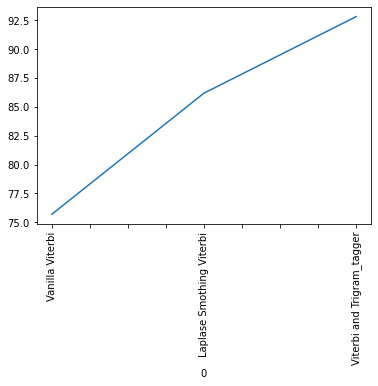

In [53]:
# Let's compare the accuracy
accuracy_metrics = {
    'Vanilla Viterbi': vanilla_viterbi_accuracy * 100, 
    'Laplase Smothing Viterbi': modified_Laplace_Viterbi_accuracy * 100,
    'Viterbi and Trigram_tagger': viterbi_modification_trigram_tagger_accuracy * 100
}
accuracy_metrics
accuracy_df = pd.DataFrame(accuracy_metrics.items())
accuracy_df.set_index(0, inplace = True)
accuracy_df.plot.line(rot = 90, legend = False)

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

Since we are getting best accuracy with Viterbi backed by trigram tagger. Therefore we will use Viterbi backed by trigram tagger to compare the accuracy to that of Vanilla Viterbi.

In [54]:
df_vanilla = pd.DataFrame(vanilla_tagged_seq, columns=['words', 'Vanilla POS tag'])
df_vanilla.shape

(181, 2)

In [55]:
df_viterbi_trigram = pd.DataFrame(viterbi_trigram_tagged_seq, columns=['words', 'viterbi_trigram POS tag'])
df_viterbi_trigram.shape

(181, 2)

In [56]:
df_nltk = pd.DataFrame(test_sent_words, columns=['words', 'NLTK POS tag'])
df_nltk.shape

(181, 2)

In [57]:
merged_df = pd.merge(df_vanilla, df_viterbi_trigram, on='words', how= 'left')
merged_df = merged_df.drop_duplicates()
merged_df.head()

,words,Vanilla POS tag,viterbi_trigram POS tag
0,Android,CONJ,NOUN
2,is,VERB,VERB
6,a,DET,DET
10,mobile,ADJ,ADJ
11,operating,NOUN,NOUN


In [58]:
merged_labelled_df = pd.merge(merged_df, df_nltk, on='words', how= 'left')
merged_labelled_df = merged_labelled_df.drop_duplicates()
merged_labelled_df.head()

,words,Vanilla POS tag,viterbi_trigram POS tag,NLTK POS tag
0,Android,CONJ,NOUN,NOUN
2,is,VERB,VERB,VERB
6,a,DET,DET,DET
10,mobile,ADJ,ADJ,ADJ
11,operating,NOUN,NOUN,NOUN


In [59]:
merged_df_wrong_taggged = merged_labelled_df[merged_labelled_df['Vanilla POS tag'] != merged_labelled_df[
    'viterbi_trigram POS tag']]
merged_df_wrong_taggged

,words,Vanilla POS tag,viterbi_trigram POS tag,NLTK POS tag
0,Android,CONJ,NOUN,NOUN
15,Google,CONJ,NOUN,NOUN
42,OS,CONJ,NOUN,NOUN
43,worldwide,CONJ,NOUN,NOUN
47,smartphones,CONJ,VERB,NOUN
50,2011,CONJ,NUM,NUM
59,2013,CONJ,NUM,NUM
60,Twitter,CONJ,NOUN,NOUN
70,2015,CONJ,NUM,NUM
71,that,DET,ADP,DET


`Inference: ` There are 30 unique words as given below:
'Android', 'Google', 'OS', 'worldwide', 'smartphones', '2011',
       '2013', 'Twitter', '2015', 'firehose', 'online', 'interact',
       'messages', 'known', 'tweets', 'domineering', 'personality',
       '2018', 'FIFA', 'Cup', '21st', 'tournament', 'contested', '11th',
       'trips', 'arriving', 'NASA', 'invited', 'ICESAT-2' and 'Satellite' which were not tagged properly. But were tagged properly with modified version of vanilla viterbi.

In [60]:
merged_df_wrong_taggged['words'].nunique()

30

`Inference: ` There are 30 words in that were differently tagged with Viterbi and trigram combination }as compared to Vanilla Tagger.

In [61]:
merged_df_wrong_taggged[merged_df_wrong_taggged['NLTK POS tag'] != merged_df_wrong_taggged['viterbi_trigram POS tag']]

,words,Vanilla POS tag,viterbi_trigram POS tag,NLTK POS tag
47,smartphones,CONJ,VERB,NOUN
71,that,DET,ADP,DET
85,online,CONJ,NOUN,ADJ
97,messages,CONJ,VERB,NOUN
109,domineering,CONJ,VERB,ADJ
173,arriving,CONJ,VERB,NOUN


`Inference: ` Considering NLTK POS tagger as the source of truth, there are 5
words which are not tagged properly even with Viterbi with trigram backoff with rule based tagger. Let's omit these words out from the analysis.

In [62]:
analysis_df = merged_df_wrong_taggged[merged_df_wrong_taggged['NLTK POS tag'] == merged_df_wrong_taggged[
    'viterbi_trigram POS tag']]
analysis_df

,words,Vanilla POS tag,viterbi_trigram POS tag,NLTK POS tag
0,Android,CONJ,NOUN,NOUN
15,Google,CONJ,NOUN,NOUN
42,OS,CONJ,NOUN,NOUN
43,worldwide,CONJ,NOUN,NOUN
50,2011,CONJ,NUM,NUM
59,2013,CONJ,NUM,NUM
60,Twitter,CONJ,NOUN,NOUN
70,2015,CONJ,NUM,NUM
72,that,DET,ADP,ADP
81,'s,VERB,PRT,PRT


`Inference: ` There are 25 words that are tagged incorrectly with Vanila Viterbi but were tagged correctly with Viterbi and Trigram combination.

From the above table we can see following:
1. Most of the numbers were not tagged correctly with Vanilla Viterbi. And reason is obivous, since these words doesn't appear in the the training corpus.
2. Most of the nouns are not tagged correctly by the Vanilla Viterbi algorithm.

## Conclusion
For the sample sentences given Viterbi with Trigram cobination works best. And is giving high accuracy of 93%. The drop in accuracy is majorly because of noun and adjactives labelled incorrectly.

But when compared to Vanilla Viterbi which is giving accuray of 76% our modified version performed well.